In [2]:
import sys

# gems_tco_path = "/Users/joonwonlee/GEMS_TCO/"
# sys.path.append(gems_tco_path)

# Print the current system path
for path in sys.path:
    print(path)

# '/Users/joonwonlee/GEMS_TCO/Exercises'

/opt/anaconda3/envs/gems_tco/lib/python313.zip
/opt/anaconda3/envs/gems_tco/lib/python3.13
/opt/anaconda3/envs/gems_tco/lib/python3.13/lib-dynload

/opt/anaconda3/envs/gems_tco/lib/python3.13/site-packages
/Users/joonwonlee/GEMS_TCO/


If needed, install graphviz above

In [1]:
# work environment: jl2815
# Standard libraries
import sys
gems_tco_path = "/Users/joonwonlee/GEMS_TCO/"
sys.path.append(gems_tco_path)


import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports

from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim


load data

In [2]:
lat_lon_resolution = [10,10]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]
# params= [20, 8.25, 5.25, 0.2, 0.5, 5]


# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= [8,16]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Condition number

In [3]:
# Define your initial parameters
params = [20, 8.25, 5.25, 0.2, 0.5, 5]
params = [21.8, 1.09, 1.17, 0.2, 0.5, 1]

params = torch.tensor(params, requires_grad=True)


torch_smooth = torch.tensor(0.5, dtype=torch.float32)

instance = kernels.likelihood_function_testing(smooth=torch_smooth , input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)

out0 = instance.full_likelihood(params, aggregated_np[:,:4],aggregated_np[:,2], instance.matern_cov_yx)
print(out0)

out0 = instance.vecchia_like_local(params, instance.matern_cov_yx)
print(out0)


tensor(2390.4375, grad_fn=<MulBackward0>)
tensor(2484.8418, grad_fn=<AddBackward0>)


In [18]:
def matern_cov_yx( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

  
    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices]/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

def matern_cov_yx2( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U= coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out


def full_likelihood( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)

    return log_det, quad_form, neg_log_lik
params = [20, 8.25, 5.25, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)



def matern_partial_sigma( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = torch.exp(-distance[non_zero_indices]/range_)
    out[~non_zero_indices] = 1


    return out

def matern_partial_range( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]
 
    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices] / range_)
    out[~non_zero_indices] = sigmasq

    # Compute the derivative with respect to the range parameter
    derivative = torch.zeros_like(distance)
    if torch.any(non_zero_indices):
        derivative[non_zero_indices] = out[non_zero_indices] * distance[non_zero_indices] / range_**2

    # Ensure the derivative on the diagonal is zero
    derivative.fill_diagonal_(0)
    
    return derivative

def matern_partial_nugget( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    
    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = 0
    out[~non_zero_indices] = 1

    return out

def matern_partial_beta( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)


    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        tmp1 = sigmasq * torch.exp(-distance[non_zero_indices]/range_)*(-1/range_)
        
        tmp2 = (beta/distance[non_zero_indices])

                # Adjust t2 - t1 for non-zero indices
        t1_non_zero = t1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        t2_non_zero = t2.unsqueeze(0).expand_as(distance)[non_zero_indices]

        out[non_zero_indices] = tmp1 * tmp2 *(t2_non_zero - t1_non_zero)**2

    out[~non_zero_indices] = 0

    return out

def matern_partial_advec( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)


    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        tmp1 = sigmasq * torch.exp(-distance[non_zero_indices]/range_)*(-1/range_)

        # Adjust t2 - t1 for non-zero indices
        t1_non_zero = t1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        t2_non_zero = t2.unsqueeze(0).expand_as(distance)[non_zero_indices]
        x1_non_zero = x1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        x2_non_zero = x2.unsqueeze(0).expand_as(distance)[non_zero_indices]
        y1_non_zero = y1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        y2_non_zero = y2.unsqueeze(0).expand_as(distance)[non_zero_indices]

        tmp2 = (t2_non_zero - t1_non_zero )
        tmp3 = tmp2* ( (x1_non_zero-x2_non_zero) - advec*(t1_non_zero - t2_non_zero) +  (y1_non_zero-y2_non_zero) - advec*(t1_non_zero - t2_non_zero) )

        out[non_zero_indices] = tmp1* (1/ distance[non_zero_indices]) * tmp3

    out[~non_zero_indices] = 0
    return out

def full_partial( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function, partial_fun) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    partial_der = partial_fun(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    # sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    tmp1 = torch.linalg.solve(cov_matrix, partial_der)
    tmp2 = torch.matmul(y_mu, tmp1)
    tmp3 = torch.linalg.solve(cov_matrix, y_mu)
    quad_form =  -torch.matmul(tmp2,tmp3 )
    log_det = torch.trace(tmp1)
    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)
    
    return log_det, quad_form, neg_log_lik

params = [20, 8.25, 5.25, 0.2, 0.5, 0.5]
params = torch.tensor(params, requires_grad=True)



a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_sigma)
print(f'sigma log_det:{a}')
print(f'sigma quad_form:{b}')
print(f'sigma quad_form:{c}')

a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_range)
print(f'\nrange log_det:{a}')
print(f'range quad_form:{b}')
print(f'range quad_form:{c}')

a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_nugget)
print(f'\nnugget log_det:{a}')
print(f'nugget quad_form:{b}')
print(f'nugget quad_form:{c}')

matern_partial_sigma(params, aggregated_np[:,:4], aggregated_np[:,:4])
a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_beta)
print(f'\nbeta log_det:{a}')
print(f'beta quad_form:{b}')
print(f'beta quad_form:{c}')

matern_partial_sigma(params, aggregated_np[:,:4], aggregated_np[:,:4])
a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_advec)
print(f'\nadvec log_det:{a}')
print(f'advec quad_form:{b}')
print(f'advec quad_form:{c}')

sigma log_det:52.751075744628906
sigma quad_form:-178.46905517578125
sigma quad_form:-62.85898971557617

range log_det:-126.85022735595703
range quad_form:428.3491516113281
range quad_form:150.7494659423828

nugget log_det:1089.956787109375
nugget quad_form:-4008.744140625
nugget quad_form:-1459.3936767578125

beta log_det:599.5938720703125
beta quad_form:-1225.3087158203125
beta quad_form:-312.857421875

advec log_det:61.72579574584961
advec quad_form:934.9284057617188
advec quad_form:498.32708740234375


In [19]:


params = [24.42, 1.92, 1.92, -0.045, 0.237, 3.34]
params = torch.tensor(params, requires_grad=True)

params = [23.59, 3.83, 3.83, 0.036, 0.277, 2.83]
params = torch.tensor(params, requires_grad=True)

# Choose your optimizer
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]
params = torch.tensor(params, requires_grad=True)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    logdet, quad, nll = full_likelihood(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx2)
    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(21):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 


Epoch 1, Gradients: [ -134.65918   324.66626     0.       1042.523   -4573.7373  -4248.741  ]
 Loss: 4449.5498046875, Parameters: [20.    8.25  5.25  0.2   0.2   0.2 ]
Epoch 2, Gradients: [ -129.13696   311.86356     0.        719.6832  -4065.7153  -4025.1755 ]
 Loss: 4351.859375, Parameters: [20.01        8.24        5.25        0.19        0.21000001  0.21000001]
Epoch 3, Gradients: [ -124.07056   300.12036     0.        462.28958 -3678.2468  -3826.9248 ]
 Loss: 4263.71875, Parameters: [20.02001     8.22999     5.25        0.18006083  0.22001731  0.22001223]
Epoch 4, Gradients: [ -119.394775   289.28024      0.         269.6099   -3376.3909
 -3646.986   ]
 Loss: 4183.1767578125, Parameters: [20.030037    8.219965    5.25        0.17026903  0.230063    0.23004392]
Epoch 5, Gradients: [ -115.052246   279.21698      0.         136.72504  -3131.6855
 -3480.149   ]
 Loss: 4108.64013671875, Parameters: [20.040085    8.209918    5.25        0.16074158  0.24014701  0.24010181]
Epoch 6, Gradi

Make Class using analytical derivatives

In [7]:
import copy
class matern_advec_beta:
    def __init__(self, aggregated_np: torch.Tensor, params: torch.Tensor):
        self.aggregated_np = aggregated_np[:,:4]
        self.y = aggregated_np[:,2]
        self.aggregated_locs = aggregated_np[:,:2]
        aggregated_np_clone = copy.deepcopy(aggregated_np)
        self.x1 = aggregated_np[:,0]
  
        self.y1 = aggregated_np[:,1]
        self.t1 = aggregated_np[:,3]

        self.x2 = aggregated_np_clone[:,0]
        self.y2 = aggregated_np_clone[:,1]
        self.t2 = aggregated_np_clone[:,3] 
        self.params = params 

        self.distance, self.non_zero_indices = self.precompute_coords(params)
                # Adjust t2 - t1 for non-zero indices
        self.t1_non_zero = self.t1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.t2_non_zero = self.t2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.x1_non_zero = self.x1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.x2_non_zero = self.x2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.y1_non_zero = self.y1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.y2_non_zero = self.y2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
    
    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = torch.sqrt(spatial_diff**2 + temporal_diff**2)  # Keeping torch.sqrt for proper gradients
        return distance

    def precompute_coords(self, params)-> torch.Tensor:
        igmasq, range_,  advec, beta, nugget = params
        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec * self.t1, self.y1 ), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec * self.t2, self.y2 ), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices

    def matern_advec_beta_cov(self,params) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params
        
        out = torch.zeros_like(self.distance)

        out[self.non_zero_indices] = sigmasq * torch.exp(- (self.distance[self.non_zero_indices])/range_)
        out[~self.non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out


    def matern_partial_sigma(self, params) -> torch.Tensor:
        sigmasq, range_, advec, beta, nugget = params
        out = torch.zeros_like(self.distance)

        # Cache the non-zero indices distance
        non_zero_distance = self.distance[self.non_zero_indices]

        # Compute the exponential term
        exp_term = torch.exp_(-non_zero_distance / range_)

        # Assign the computed values to the output tensor
        out[self.non_zero_indices] = exp_term
        out[~self.non_zero_indices] = 1

        return out

    def matern_partial_range(self, params: torch.Tensor ) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params

        out = torch.zeros_like(self.distance)
    
        tmp = sigmasq * torch.exp(-(self.distance[self.non_zero_indices]) / range_) 
        out[self.non_zero_indices] = tmp * (self.distance[self.non_zero_indices])  / range_**2

        return out
    def matern_partial_nugget(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params

        out = torch.zeros_like(self.distance)

   
        out[self.non_zero_indices] = 0
        out[~self.non_zero_indices] = 1

        return out

    def matern_partial_advec(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params


        out = torch.zeros_like(self.distance)

        tmp1 = sigmasq * torch.exp(-(self.distance[self.non_zero_indices]) /range_)*(-1/range_)


        tmp2 = (self.t2_non_zero - self.t1_non_zero )
        tmp3 = tmp2* ( (self.x1_non_zero-self.x2_non_zero) - advec*(self.t1_non_zero - self.t2_non_zero) +  (self.y1_non_zero-self.y2_non_zero) - advec*(self.t1_non_zero - self.t2_non_zero) )

        out[self.non_zero_indices] = tmp1* (1/ (self.distance[self.non_zero_indices]) ) * tmp3

        out[~self.non_zero_indices] = 0
        return out
    
    def matern_partial_beta(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params
    

        out = torch.zeros_like(self.distance)

        tmp1 = sigmasq * torch.exp(-(self.distance[self.non_zero_indices])/range_)*(-1/range_)
        
        tmp2 = (beta/(self.distance[self.non_zero_indices]))


        out[self.non_zero_indices] = tmp1 * tmp2 *(self.t2_non_zero - self.t1_non_zero)**2

        out[~self.non_zero_indices] = 0

        return out
    

    def cov_and_inv(self, params):
        cov_matrix = self.matern_advec_beta_cov( params=params)
        cov_inv = torch.linalg.inv(cov_matrix)
                
        # Compute beta
        tmp1 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.aggregated_locs))
        tmp2 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.y))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(self.aggregated_locs, beta)
        y_mu = self.y - mu
        tmp3 = torch.matmul(cov_inv, y_mu)
        return cov_matrix, cov_inv, mu, tmp3
    
    def full_partial(self, params: torch.Tensor, partial_der_fun, cov_matrix, cov_inv,mu, tmp3) -> torch.Tensor:
        

        partial_der = partial_der_fun(params)
        
        # Compute the log determinant of the covariance matrix
        # sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        y_mu = self.y - mu

        # Compute the quadratic form derivative
        # tmp1 = torch.linalg.solve(cov_matrix, partial_der)
        tmp1 = torch.matmul( cov_inv, partial_der)

        tmp2 = torch.matmul(y_mu, tmp1)

        # tmp3 = torch.matmul(cov_inv, y_mu)
        # tmp3 = torch.linalg.solve(cov_matrix, y_mu)

        quad_form_derivative  =  -torch.matmul(tmp2,tmp3 )
        log_det_derivative = torch.trace(tmp1)
        # Compute the negative log likelihood
        neg_log_lik_derivative = 0.5 * (log_det_derivative  + quad_form_derivative )
        
        return log_det_derivative , quad_form_derivative , neg_log_lik_derivative 
    
    def full_likelihood(self, params, covariance_function ,cov_matrix, cov_inv, mu) -> torch.Tensor:
        input_arr = self.aggregated_np
        y_arr = self.y

        # Compute the covariance matrix
        #cov_matrix = covariance_function(params=params)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        locs = input_arr[:, :2]

        # Compute beta
        # tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
        # tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
        # beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        # mu = torch.matmul(locs, beta)
        y_mu = y_arr - mu

        # Compute the quadratic form
        # quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))
        tmp = torch.matmul( cov_inv, y_mu)
        quad_form = torch.matmul( y_mu, tmp)

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)

        return neg_log_lik
    
    
    def matern_advec_beta_optim(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, epochs=10, tol=1e-3):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        params = self.params.to(device)  # Assuming params is a tensor and moving it to the device
        
        # Initialize tensors and move to GPU if available
        m = torch.zeros_like(params, device=device)
        v = torch.zeros_like(params, device=device)
        
        b1 = torch.tensor(beta1, device=device)
        b2 = torch.tensor(beta2, device=device)

        prev_neg_log_lik = float('inf')
        
        for epoch in range(epochs):
            self.distance, self.non_zero_indices = self.precompute_coords(params)

            if epoch ==0:
                cov_matrix, cov_inv, mu, tmp3 = self.cov_and_inv(params)
                
            _, _, g_sigma = self.full_partial(params, self.matern_partial_sigma,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_range = self.full_partial(params, self.matern_partial_range,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_advec = self.full_partial(params, self.matern_partial_advec,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_beta = self.full_partial(params, self.matern_partial_beta,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_nugget = self.full_partial(params, self.matern_partial_nugget,cov_matrix, cov_inv, mu, tmp3)

            g = torch.stack([g_sigma, g_range, g_advec, g_beta, g_nugget]).to(device)

            # Update m and v
            m = b1 * m + (1 - b1) * g
            v = b2 * v + (1 - b2) * g**2

            # Bias correction
            m_hat = m / (1 - b1**(epoch + 1))
            v_hat = v / (1 - b2**(epoch + 1))

            # Update params
            params = params - lr * m_hat / ( torch.sqrt(v_hat) + epsilon)

            cov_matrix, cov_inv, mu, tmp3 = self.cov_and_inv(params)
            # Compute the current negative log likelihood
            neg_log_lik = self.full_likelihood(params, self.matern_advec_beta_cov,cov_matrix, cov_inv, mu)
            
            # Print params and likelihood every 10th epoch
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: loss: {neg_log_lik}, \nParams = {params} ")

            # Check for convergence
            if abs(prev_neg_log_lik - neg_log_lik) < tol:
                print(f"Converged at epoch {epoch}")
                break
            
            prev_neg_log_lik = neg_log_lik
        return params



params = [24.56, 2.8, -.0138, .301, 2.12]
# 2222 2224 2222  long only 
# 2223  2222 2221 both same advection
# 2223 2222 2221 lat only
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta(aggregated_np, params)
epochs=21
instance.matern_advec_beta_optim(lr=0.01,beta1=0.9, beta2= 0.8, epsilon=1e-8, epochs=epochs)



Epoch 0: loss: 2223.1083984375, 
Params = tensor([ 2.4550e+01,  2.8100e+00, -3.8000e-03,  2.9100e-01,  2.1100e+00],
       grad_fn=<SubBackward0>) 
Epoch 10: loss: 2222.6416015625, 
Params = tensor([24.5433,  2.9069,  0.0925,  0.2845,  2.1290], grad_fn=<SubBackward0>) 
Epoch 20: loss: 2221.22900390625, 
Params = tensor([24.5904,  2.9989,  0.0576,  0.2692,  2.2199], grad_fn=<SubBackward0>) 


tensor([24.5904,  2.9989,  0.0576,  0.2692,  2.2199], grad_fn=<SubBackward0>)

Make class for torch optimization frame

In [ ]:

class matern_advec_beta_torch:
    def __init__(self, aggregated_np: torch.Tensor, params: torch.Tensor):
        self.aggregated_np = aggregated_np[:,:4]
        self.y = aggregated_np[:,2]
        self.aggregated_locs = aggregated_np[:,:2]

        aggregated_np_clone = copy.deepcopy(aggregated_np)
        self.x1 = aggregated_np[:,0]
        self.y1 = aggregated_np[:,1]
        self.t1 = aggregated_np[:,3]

        self.x2 = aggregated_np_clone[:,0]
        self.y2 = aggregated_np_clone[:,1]
        self.t2 = aggregated_np_clone[:,3] 
        self.params = params 

        self.distance, self.non_zero_indices = self.precompute_coords(params)
        # Adjust t2 - t1 for non-zero indices
        self.t1_non_zero = self.t1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.t2_non_zero = self.t2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.x1_non_zero = self.x1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.x2_non_zero = self.x2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.y1_non_zero = self.y1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.y2_non_zero = self.y2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
    
    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
        return distance

    def precompute_coords(self, params)-> torch.Tensor:
        sigmasq, range_,  advec_lat, advec_lon, beta, nugget = params

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec_lat * self.t1, self.y1 - advec_lon * self.t1), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec_lat * self.t2, self.y2 - advec_lon * self.t2), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices

    def matern_advec_beta_cov(self,params) -> torch.Tensor:
        sigmasq, range_, advec_lat, advec_lon, beta, nugget = params
        
        distance, non_zero_indices = self.precompute_coords(params)
        out = torch.zeros_like(distance)
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)

        out[~self.non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
 
    def full_likelihood(self, params, covariance_function) -> torch.Tensor:

        # Compute the covariance matrix
        cov_matrix = covariance_function(params=params)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)

        if sign <= 0:
            raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        # locs = input_arr[:, :2]

        # Compute beta
        tmp1 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.aggregated_locs))
        tmp2 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.y))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(self.aggregated_locs, beta)
        # y_mu = y_arr - mu
        y_mu = self.y - mu

        # Compute the quadratic form
        quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))
     

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)
        return neg_log_lik
    
    

In [21]:
params = [24.56, 2.8,  -0.0138, -0.0138, 0.301, 2.12]
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta_torch(aggregated_np, params)

instance.full_likelihood(params, instance.matern_advec_beta_cov )

tensor(2223.2944, grad_fn=<MulBackward0>)

In [27]:

# Choose your optimizer
params = [24.56, 2.8,  -0.0138, -0.0138, 0.301, 2.12]
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta_torch(aggregated_np, params)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    nll = instance.full_likelihood(params, instance.matern_advec_beta_cov )
    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(21):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 

Epoch 1, Gradients: [  0.39454293  -7.727234   -35.274902   -12.076302    39.945312
   2.9728312 ]
 Loss: 2223.29443359375, Parameters: [ 2.456e+01  2.800e+00 -1.380e-02 -1.380e-02  3.010e-01  2.120e+00]
Epoch 2, Gradients: [  0.2185049  -6.15143   -29.9124     -5.32193    19.095642    0.8873911]
 Loss: 2222.49365234375, Parameters: [ 2.4549999e+01  2.8099999e+00 -3.7999991e-03 -3.7999991e-03
  2.9100001e-01  2.1099999e+00]
Epoch 3, Gradients: [  0.04543424  -4.6179667  -25.118095     0.5244522   -2.7581177
  -1.2672343 ]
 Loss: 2222.0634765625, Parameters: [2.4540241e+01 2.8200021e+00 6.2145237e-03 5.6945160e-03 2.8140515e-01
 2.1010246e+00]
Epoch 4, Gradients: [ -0.08614326  -3.4571304  -20.108612     4.4380875  -19.795258
  -2.9859805 ]
 Loss: 2221.90625, Parameters: [2.4531586e+01 2.8299849e+00 1.6251555e-02 1.3203476e-02 2.7398443e-01
 2.0970454e+00]
Epoch 5, Gradients: [ -0.13947725  -2.9757252  -13.203423     5.7113495  -24.305511
  -3.7381105 ]
 Loss: 2221.787841796875, Paramet

In [9]:
import torch
from torch.optim import Adam

from line_profiler import LineProfiler

def matern_advec_beta_optim(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, epochs=10, tol=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    params = self.params.to(device)
    optimizer = Adam([params], lr=lr, betas=(beta1, beta2), eps=epsilon)
    prev_neg_log_lik = float('inf')
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        self.distance, self.non_zero_indices = self.precompute_coords(params)
        if epoch ==0:
            cov_matrix, cov_inv, mu, tmp3 = self.cov_and_inv(params)
            
        _, _, g_sigma = self.full_partial(params, self.matern_partial_sigma,cov_matrix, cov_inv, mu, tmp3)
        _, _, g_range = self.full_partial(params, self.matern_partial_range,cov_matrix, cov_inv, mu, tmp3)
        _, _, g_advec = self.full_partial(params, self.matern_partial_advec,cov_matrix, cov_inv, mu, tmp3)
        _, _, g_beta = self.full_partial(params, self.matern_partial_beta,cov_matrix, cov_inv, mu, tmp3)
        _, _, g_nugget = self.full_partial(params, self.matern_partial_nugget,cov_matrix, cov_inv, mu, tmp3)

        g = torch.stack([g_sigma, g_range, g_advec, g_beta, g_nugget]).to(device)

        combined_grad = g.sum(0)
        params.grad = combined_grad
        optimizer.step()
        cov_matrix, cov_inv, mu = self.cov_and_inv(params)
        neg_log_lik =self.full_likelihood(params, self.matern_advec_beta_cov,cov_matrix, cov_inv, mu)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}: loss: {neg_log_lik}, \nParams = {params} ")
        if abs(prev_neg_log_lik - neg_log_lik) < tol:
            print(f"Converged at epoch {epoch}")
            break
        prev_neg_log_lik = neg_log_lik
    return params

# Create a LineProfiler instance
profiler = LineProfiler()
profiler.add_function(instance.matern_advec_beta_optim)

# Run the function with profiling
profiler.run('instance.matern_advec_beta_optim(lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, epochs=21)')

# Print the profiling results
profiler.print_stats()


Epoch 0: loss: 2223.1083984375, 
Params = tensor([ 2.4550e+01,  2.8100e+00, -3.8000e-03,  2.9100e-01,  2.1100e+00],
       grad_fn=<SubBackward0>) 


KeyboardInterrupt: 

Sanity check for autograd and analytical gradients

Automate gradients

tensor([0.5960], grad_fn=<DivBackward0>)
tensor([0.4397], requires_grad=True)
Gradient of x: tensor([0.4397])
Gradient of b: tensor([1.])
Gradient of w: tensor([-0.5976])


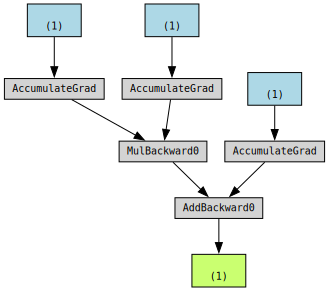

In [79]:
# Import the torch library
import torch 
from torchviz import make_dot


# Define Input variable
x = torch.randn(1, requires_grad=True)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
 
# Define the graph structure
# Forward pass
y = w * x + b
h= 1e-7
y2 = w*(x+h)+b

# Backward pass
y.backward()
 
print( (y2-y)/h) 
print(w)
#View the outputs
print("Gradient of x:", x.grad)
print("Gradient of b:", b.grad)
print("Gradient of w:", w.grad)
 
# Update parameters
w.data -= 0.01 * w.grad.data
b.data -= 0.01 * b.grad.data
 
# Plot the computational graph
make_dot(y)

In [96]:
import torch
import torch.optim as optim

# Define Input variable
x = torch.randn(1, requires_grad=True)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Define the target value
target = torch.tensor([10.0])  # Example target value

# Choose your optimizer
optimizer = optim.Adam([w, b], lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass
    y = w * x + b
    
    # Compute loss (mean squared error)
    loss = (y - target).pow(2).mean()

    # Backward pass
    loss.backward()

    # Print gradients
    print(f'Epoch {epoch+1}, Gradients: w: {w.grad.item()}, b: {b.grad.item()}')

    # Update parameters
    optimizer.step()

    # Print loss and parameters
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, w: {w.item()}, b: {b.item()}')

print('Training complete.')
print(f'Final parameters: w: {w.item()}, b: {b.item()}')

Epoch 1, Gradients: w: -34.30268859863281, b: -21.79442596435547
Epoch 2, Gradients: w: -34.22166442871094, b: -21.74294662475586
Epoch 3, Gradients: w: -34.14064407348633, b: -21.691471099853516
Epoch 4, Gradients: w: -34.05963897705078, b: -21.640003204345703
Epoch 5, Gradients: w: -33.9786376953125, b: -21.588539123535156
Epoch 6, Gradients: w: -33.89765548706055, b: -21.537086486816406
Epoch 7, Gradients: w: -33.81669235229492, b: -21.485645294189453
Epoch 8, Gradients: w: -33.73575210571289, b: -21.434219360351562
Epoch 9, Gradients: w: -33.65483474731445, b: -21.382808685302734
Epoch 10, Gradients: w: -33.57394790649414, b: -21.3314151763916
Epoch 11, Gradients: w: -33.49308776855469, b: -21.280040740966797
Epoch 12, Gradients: w: -33.412261962890625, b: -21.228689193725586
Epoch 13, Gradients: w: -33.331478118896484, b: -21.1773624420166
Epoch 14, Gradients: w: -33.250736236572266, b: -21.126060485839844
Epoch 15, Gradients: w: -33.1700325012207, b: -21.074785232543945
Epoch 16,

optimization

Previous model fitting

In [24]:
v=0.5
bounds = [(0.001, 80), (0.001, 20), (0.001, 20), (-3, 3), (0.001, 5), (0.001, 10)]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
params = [20, 8.25, 5.25, 0.2, 0.5, 0.5]
instance = kernels.model_fitting(smooth = v, input_map = analysis_data_map, nns_map = nns_map, mm_cond_number = mm_cond_number )

start_time = time.time()
# keys = sorted(analysis_data_map)
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(
            instance.mle_parallel_full,
            bounds, params, aggregated_np, aggregated_np[:,2], instance.matern_cov_yx, instance.full_likelihood
        )   
    ]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Full likelihood estimation_time took {estimation_time:.4f} seconds")

fit_st_1_27
Total iterations: 21
Estimated parameters : [21.80391488  1.09113682  1.17076466  0.2         0.5         1.04263888], when cond 10, bounds=[(0.001, 80), (0.001, 20), (0.001, 20), (-3, 3), (0.001, 5), (0.001, 10)], smooth=0.5
Full likelihood estimation_time took 40.1945 seconds


In [7]:
v=0.5
bounds = [(0.001, 100), (0.001, 80), (0.001, 80), (-3, 3), (0.001, 5), (0.001, 10)]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
instance = kernels.model_fitting(smooth = v, input_map = analysis_data_map, nns_map = nns_map, mm_cond_number = mm_cond_number )



start_time = time.time()

# keys = sorted(analysis_data_map)
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(
            instance.mle_parallel_vecc,
            bounds, params, instance.matern_cov_yx, instance.vecchia_like_local
        )   
    ]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecchia estimation_time took {estimation_time:.4f} seconds")

fit_st_1_27
conditio number 10.543913328344951
conditio number 11.269505862930176
conditio number 12.291120260583348
conditio number 12.66906250894612
conditio number 14.322793611524364
conditio number 13.462602609181584
conditio number 14.132177222869787
conditio number 12.918134943689294
conditio number 14.362435115371959
conditio number 15.207208698940029
conditio number 15.055594048634099
conditio number 13.63213064178445
conditio number 15.030506711701001
conditio number 15.483047333274477
conditio number 17.095583404664026
conditio number 16.55571256821578
conditio number 16.33997471960812
conditio number 18.080688292767718
conditio number 17.568898368446934
conditio number 17.954741222228815
conditio number 18.845025246030932
conditio number 19.263001936272758
conditio number 19.911363593827623
conditio number 21.407667521726218
conditio number 21.541236961747888
conditio number 22.06178900095315
conditio number 21.901650421640355
conditio number 22.226651222239177
conditio numb

In [ ]:
start_time = time.time()
# keys = sorted(analysis_data_map)
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(
            instance.mle_parallel_full,
            bounds, params, aggregated_np, aggregated_np[:,2], instance.matern_cov_yx, instance.full_likelihood
        )   
    ]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Full likelihood estimation_time took {estimation_time:.4f} seconds")

7min
Total iterations: 46
Estimated parameters : [19.7837812   3.98922961  4.70369695  0.5         0.5         4.6877655 ], when cond 10, bounds=[(0.05, 600), (0.05, 600), (-20, 20), (0.5, 60), (0.5, 60), (0.05, 5)], smooth=0.5
Full likelihood estimation_time took 445.9319 seconds